http://cognitivemedium.com/rmnist

CNN:
- RMNIST/1: 56.91%
- RMNIST/5: 76.65%
- RMNIST/10: 86.53%
- MNIST: 99.11%

With data transformations:
- RMNIST/1: 55.25%
- RMNIST/5: 84.38%
- RMNIST/10: 92.07%
- MNIST: 99.34%

With transfer learning:
- RMNIST/1: 51.01%
- RMNIST/5: 72.81%
- RMNIST/10: 82.95%

With transfer learning and data transformations:
- RMNIST/1: 52.84%
- RMNIST/5: 75.27%
- RMNIST/10: 84.66%

In [1]:
import data_utils

In [2]:
trX, teX, trY, teY = data_utils.load_mnist(one_hot=False)

In [3]:
print(trX.shape)
print(trX.dtype)

(60000, 784)
float64


In [4]:
print(trY.shape)

(60000,)


In [5]:
import random
import numpy as np
from collections import defaultdict

N = 5

counts = defaultdict(int) #need to keep track of how many of each digit
indices = list(range(50000))
random.shuffle(indices)

valX, valY = trX[50000:], trY[50000:]
rtrX, rtrY = np.zeros((N*10,784)), np.zeros((N*10), dtype=np.uint8)
     
i = 0
for index in indices:
    if counts[trY[index]] < N:
        rtrX[i], rtrY[i] = trX[index], trY[index]
        counts[trY[index]] += 1
        i += 1
        
print(valX.shape)
print(valX.dtype)
print(rtrX.shape)
print(rtrX.dtype)
print(valY.shape)
print(valY.dtype)
print(rtrY.shape)
print(rtrY.dtype)

(10000, 784)
float64
(50, 784)
float64
(10000,)
uint8
(50,)
uint8


2


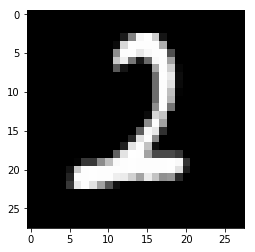

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

#view data

plt.imshow(rtrX[(N*10)-1].reshape(28,28), cmap=plt.get_cmap('gray')); #need cmap thing or else is weird colour
print(rtrY[(N*10)-1])

In [7]:
print(np.unique(rtrY, return_counts=True)) #making sure there's N of each

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5]))


In [8]:
def random_shift(X, max_shift=3, n_pixels=None):

    X = np.copy(X)
    
    if n_pixels.any() == None:
        n_pixels = np.random.randint(0,max_shift+1,4) #args are low, max, n, with max being exclusive, i.e. 0, 5, 4 produces 4 numbers between 0 and 4
    
    #shifting image up by n_pixels
    if n_pixels[0]:
        X[:28*28-n_pixels[0]*28] = X[n_pixels[0]*28:]
        X[28*28-n_pixels[0]*28:] = np.zeros(n_pixels[0]*28)
        
    #shifting image right by n_pixels
    if n_pixels[1]:
        X = X.reshape(28,28)
        X[:,n_pixels[1]:] = X[:,:28-n_pixels[1]]
        X[:,:n_pixels[1]] = np.zeros((28,n_pixels[1]))
        X = X.reshape(28*28)
        
    #shifting image down by n_pixels
    if n_pixels[2]:
        X[n_pixels[2]*28:] = X[:28*28-n_pixels[2]*28]
        X[:n_pixels[2]*28] = np.zeros(n_pixels[2]*28)
        
    #shifting image left by n_pixels
    if n_pixels[3]:
        X = X.reshape(28,28)
        X[:,:28-n_pixels[3]] = X[:,n_pixels[3]:]
        X[:,28-n_pixels[3]:] = np.zeros((28,n_pixels[3]))
        X = X.reshape(28*28)

    assert X.shape[0] == 28*28
    
    return X

In [9]:
from scipy import misc

max_shift=5 #5 got me 86%
#rotations = np.linspace(-45,+45,2)
rotations = [1]
shifts = np.zeros(((max_shift+1)**4,4), dtype=np.uint8) #values 0 to 5 (exclusive), array length of 4
count = 0

for i in range(max_shift+1):
    for j in range(max_shift+1):
        for k in range(max_shift+1):
            for l in range(max_shift+1):
                shifts[count][0] = i
                shifts[count][1] = j
                shifts[count][2] = k
                shifts[count][3] = l
                count+=1
                
assert count == (max_shift+1)**4

trX = np.zeros((rtrX.shape[0]*count*len(rotations),28*28))
trY = np.zeros((rtrX.shape[0]*count*len(rotations),))
        
count = 0
index = 0
    
for X, y in zip(rtrX, rtrY):
    for s in shifts:
        shiftedX = random_shift(X, max_shift, n_pixels=s)
        #for rot in rotations:
            #rotatedX = misc.imrotate(shiftedX.reshape(28,28), rot).reshape(28*28)
        trX[count], trY[count] = shiftedX, y  
        count += 1

In [10]:
import torch
from torch.utils.data import Dataset

class RMNIST(Dataset):
    
    def __init__(self, X, y):
        assert len(X) == len(y)
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]
        img = img.reshape(28, 28)
        img = img+np.random.normal(0,0.03,size=(28,28)) #add some random noise
        img = torch.FloatTensor(img)
        label = torch.from_numpy(np.array([label])).long()
        return (img, label)

ImportError: dlopen: cannot load any more object with static TLS

In [ ]:
batch_size = 10

train_dataset = RMNIST(trX, trY)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_dataset = RMNIST(valX, valY)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(F.dropout2d(self.conv2(x), 0.5), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5) #prob it will be zero
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
model = Net()

lr = 0.1
momentum = 0
epochs = 500

In [ ]:
from torch.autograd import Variable
import torch.optim as optim

def train(model, epoch):
    
    optimizer = optim.SGD(model.parameters(), lr=lr*((0.8)**(epoch/10+1)), momentum=momentum)
    
    model.train()
    
    for i, (X, y) in enumerate(train_loader):
        
        X, y = Variable(X), Variable(y)
        optimizer.zero_grad()
        output = model(X)
        loss = F.nll_loss(output, y.squeeze(1))
        loss.backward()
        optimizer.step()

In [ ]:
def predict(model):
    
    model.eval()
    
    correct = 0
    
    for i, (X, y) in enumerate(val_loader):
        
        X, y = Variable(X), y.squeeze(1)
        outputs = model(X)
        _, predicted = torch.max(outputs.data, 1)
        batch_correct = (predicted == y).sum()
        correct += batch_correct
        
    return correct/len(val_loader)*batch_size

In [ ]:
import torch.optim as optim

for epoch in range(1, epochs+1):
    
    train(model, epoch)
    acc = predict(model)
    print(f'Epoch: {epoch}, Acc: {acc}')

In [ ]:
import scipy

X = rtrX[(N*10)-1]

plt.imshow(X.reshape(28,28), cmap=plt.get_cmap('gray')); #need cmap thing or else is weird colour

In [ ]:
from scipy import misc

plt.imshow(misc.imrotate(X.reshape(28,28), -45), cmap=plt.get_cmap('gray')); #need cmap thing or else is weird colour

In [ ]:
plt.imshow(misc.imrotate(X.reshape(28,28), -35), cmap=plt.get_cmap('gray')); #need cmap thing or else is weird colour

In [ ]:
np.linspace(-45,+45,2)